# Quantum Walk

## Intoduction
This notebook covers the detailed explanation of the quantum walk on a line with 16 nodes, the necessary code to implement it using the Classiq framework, and a simple visualization of the quantum walk probabilities. The key components include initializing the quantum states, defining the probability distributions for the walk, and performing the walk using quantum operators. Adjustments are made to handle the boundary conditions of the line topology.

## Quantum Walks: Theory

A quantum walk is the quantum analog of a classical random walk, which involves moving to adjacent states (or nodes) with certain probabilities. Quantum walks leverage superposition and interference, leading to different dynamics compared to classical random walks. \\
There are two main types of quantum walks: discrete-time and continuous-time. Here, we focus on discrete-time quantum walks.

### Discrete-Time Quantum Walk

A discrete-time quantum walk is generally composed of two main operators:
1. **Coin Operator \( C \)** \\
This operator "flips" a quantum coin to determine the direction of the walk.
   The coin operator acts on the coin space and can be any unitary operator. A common choice is the Hadamard operator \( H \):
   $$
   H = \frac{1}{\sqrt{2}} \begin{pmatrix}
   1 & 1 \\
   1 & -1
   \end{pmatrix}
   $$
   This operator creates an equal superposition of the coin states.

2. **Shift Operator \( S \)** \\
This operator moves the walker to the adjacent node based on the coin state.
   The shift operator moves the walker to the next or previous node based on the coin state. For a general graph with nodes \( 0 \) to \( N-1 \):
   $$
   S = \sum_{x=0}^{N-1} \left( |(x+1) \mod N \rangle \langle x| \otimes |0\rangle \langle 0| + |(x-1) \mod N \rangle \langle x| \otimes |1\rangle \langle 1| \right)
   $$
   This operator is adapted for the specific topology of the graph (e.g., a circle or a line).

#### Quantum Walk Operator \( U \)
   The overall quantum walk operator is a combination of the coin and shift operators:
   $$
   U = S \cdot (I \otimes C)
   $$
   where \( I \) is the identity operator on the position space.

#### Applying to a Line with 16 Nodes

For a line with 16 nodes, the shift operator must account for boundary conditions where nodes have fewer neighbors. The shift operator for a line with 16 nodes, where $ 0 \leq x \leq 15 $, can be defined as:
   $$
   S = \sum_{x=0}^{15} \left(
   \begin{cases}
     |x+1 \rangle \langle x| \otimes |0\rangle \langle 0| + |x-1 \rangle \langle x| \otimes |1\rangle \langle 1| & \text{if } 0 < x < 15 \\
     |x+1 \rangle \langle x| \otimes |0\rangle \langle 0| & \text{if } x = 0 \\
     |x-1 \rangle \langle x| \otimes |1\rangle \langle 1| & \text{if } x = 15
   \end{cases}
   \right)
   $$



##Implemenation in Classiq

 #### 1. Installation of Classiq Libraries

In [174]:
 #pip install -U classiq

In [175]:
 #import classiq
 #classiq.authenticate()

In [176]:
 #!pip install networkx matplotlib classiq

#### 2. Importing Necessary Libraries

In [177]:
from classiq import *
import networkx as nx
import matplotlib.pyplot as plt

#### 3. Defining the Quantum Register Size
We define the size of the quantum register. For 16 nodes, we need 4 qubits since $2^4=16$.

In [178]:
size = 4

#### 4. Preparing the Minus State
The `prepare_minus` function prepares the minus state by applying the Pauli-X gate followed by the Hadamard gate on a qubit. The minus state is ${∣−⟩}=\dfrac{∣0⟩−∣1⟩}{2}$​.

In [179]:
@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

#### 5. Diffuser Oracle
The `diffuzer_oracle` function is used to flip the auxiliary qubit if the input qubit $x$ is not zero. This is part of the amplitude amplification process.

In [180]:
@qfunc
def diffuzer_oracle(aux: Output[QNum], x: QNum):
    aux ^= (x != 0)

#### 6. Zero Diffuser
The `zero_diffuzer` function allocates an auxiliary qubit and prepares it in the minus state. It then applies the diffuser oracle on the input qubit $x$

In [181]:
@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1, aux)
    within_apply(compute=lambda: prepare_minus(aux),
                 action=lambda: diffuzer_oracle)

#### 6. C Iteration
The `C_iteration` function sets up the probability distribution for moving to adjacent nodes. It ensures that the probabilities sum to 1 and respects the boundary conditions of the line topology. It then controls the operation based on the current vertex and prepares the state accordingly.

In [182]:
def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0] * 16
    # prob[(i+1)% 16]=0.5
    # prob[(i-1)% 16]=0.5
    if i > 0 and i < 15:
        prob[i - 1] = 0.5
        prob[i + 1] = 0.5
    elif i == 0:
        prob[i + 1] = 1.0
    elif i == 15:
        prob[i - 1] = 1.0
    print(f'State={i}, prob vec ={prob}')

    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


#### 7. C Operator
The `C_operator` function iterates over all possible states (from 0 to 15) and applies the C_iteration function to each state. This sets up the probability distributions for the quantum walk.

In [183]:
@qfunc
def C_operator(vertices: QNum, adjacent_vertices: QNum):
    for i in range(2 ** size):
        C_iteration(i, vertices, adjacent_vertices)

#### 8. Edge Oracle
The `edge_oracle` function checks if the sum of the current vertex and the adjacent vertex is odd, and sets the result qubit accordingly. This helps in defining the conditions for the swap operation.

In [184]:
@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices + adjacent_vertices) % 2) == 1)

#### 9. Bitwise Swap
The `bitwise_swap` function swaps the states of two qubit arrays bit by bit. It iterates over each bit and applies the SWAP gate.

In [185]:
@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    repeat(count=x.len,
           iteration=lambda i: SWAP(x[i], y[i]))

#### 10. S Operator
The `S_operator` function applies the edge oracle to check the swap condition and then performs the bitwise swap if the condition is met.

In [186]:
@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl=res == 1,
            operand=lambda: bitwise_swap(vertices, adjacent_vertices))

#### 11. Main Function
The `main` function initializes the quantum walk by applying a Hadamard transform to create a superposition of all possible states and allocates the necessary qubits for the vertices and adjacent vertices. It then applies the C and S operators to perform the quantum walk.

In [187]:
@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
    allocate(size, vertices)
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)

    C_operator(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)

#### 12. Creating the Quantum Model
These lines create the quantum model, synthesize the quantum program, and display it in the Classiq Ide.

In [188]:
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0

#### 13. Visualizing the Quantum Walk
This part of the code defines a simple visualization of the quantum walk on a line with 16 nodes. It performs a few iterations of the walk and plots the resulting probabilities for each node.

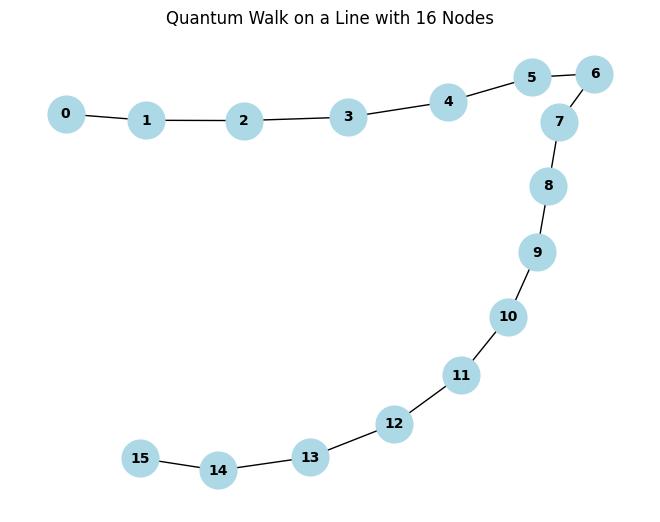

In [189]:
def visualize_line_graph(num_nodes):
    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i)
    for i in range(num_nodes):
        if i > 0:
            G.add_edge(i, i-1)
        if i < num_nodes - 1:
            G.add_edge(i, i+1)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=10, font_weight='bold')
    plt.title('Quantum Walk on a Line with 16 Nodes')
    plt.show()

visualize_line_graph(16)

#All the Code Together

In [190]:
from classiq import *
import networkx as nx
import matplotlib.pyplot as plt

size = 4

@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum], x: QNum):
    aux ^= (x != 0)

@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1, aux)
    within_apply(compute=lambda: prepare_minus(aux),
                 action=lambda: diffuzer_oracle)

def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0] * 16
    if i > 0 and i < 15:
        prob[i - 1] = 0.5
        prob[i + 1] = 0.5
    elif i == 0:
        prob[i + 1] = 1.0
    elif i == 15:
        prob[i - 1] = 1.0
    # print(f'State={i}, prob vec ={prob}')

    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

@qfunc
def C_operator(vertices: QNum, adjacent_vertices: QNum):
    for i in range(2 ** size):
        C_iteration(i, vertices, adjacent_vertices)

@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices + adjacent_vertices) % 2) == 1)

@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    repeat(count=x.len,
           iteration=lambda i: SWAP(x[i], y[i]))

@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl=res == 1,
            operand=lambda: bitwise_swap(vertices, adjacent_vertices))

@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
    allocate(size, vertices)
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)

    C_operator(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
# show(qprog)

def visualize_line_graph(num_nodes):
    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i)
    for i in range(num_nodes):
        if i > 0:
            G.add_edge(i, i-1)
        if i < num_nodes - 1:
            G.add_edge(i, i+1)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=10, font_weight='bold')
    plt.title('Quantum Walk on a Line with 16 Nodes')
    plt.show()

# visualize_line_graph(16)